In [20]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import networkx as nx

In [2]:
out_dir = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
with open(os.path.join(out_dir , 'oriented.json'), 'r') as f:
    spline_dict = json.load(f)
    nFrames = len(spline_dict.keys())
spline_dict = {int(k): v for k, v in spline_dict.items()}
spline_data = np.zeros((nFrames,350,2)) # (frames,points,(x,y))
for i in range(nFrames):
    spline_data[i,:,:] = np.array(spline_dict[i])

In [3]:
spline_data.shape

(1200, 350, 2)

# similarity and graph

In [4]:
# Posture similarity + registration-graph construction
# Input: splines of shape (T, P, 2) = (timepoints, points_along_spline, x/y)
# Example: splines.shape == (1200, 350, 2)

import numpy as np

# Optional but helpful:
from scipy.signal import savgol_filter
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt


# ----------------------------
# 1) Utilities / preprocessing
# ----------------------------

def arc_length_parametrization(xy: np.ndarray) -> np.ndarray:
    """
    xy: (P,2) points along spline
    returns s: (P,) cumulative arc-length normalized to [0,1]
    """
    d = np.diff(xy, axis=0)
    ds = np.sqrt((d**2).sum(axis=1))
    s = np.concatenate([[0.0], np.cumsum(ds)])
    if s[-1] <= 0:
        return np.linspace(0, 1, len(s))
    return s / s[-1]


def resample_spline(xy: np.ndarray, P_out: int = 350) -> np.ndarray:
    """
    Resample spline to P_out points uniformly in arc-length.
    xy: (P,2)
    returns: (P_out,2)
    """
    s = arc_length_parametrization(xy)
    s_new = np.linspace(0, 1, P_out)
    x_new = np.interp(s_new, s, xy[:, 0])
    y_new = np.interp(s_new, s, xy[:, 1])
    return np.stack([x_new, y_new], axis=1)


def smooth_spline(xy: np.ndarray, window: int = 21, poly: int = 3) -> np.ndarray:
    """
    Savitzky-Golay smoothing along the spline index.
    window must be odd and <= P.
    """
    P = xy.shape[0]
    w = min(window, P if P % 2 == 1 else P - 1)
    w = max(w, poly + 2 + (poly + 2) % 2)  # ensure odd and > poly
    x = savgol_filter(xy[:, 0], w, poly, mode="interp")
    y = savgol_filter(xy[:, 1], w, poly, mode="interp")
    return np.stack([x, y], axis=1)


# ---------------------------------------
# 2) Posture feature extraction (angles)
# ---------------------------------------

def posture_feature_angles(xy: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """
    Convert a centerline spline into a posture feature vector based on tangent angles.
    This is translation/scale invariant; rotation is mostly removed by using angle *differences*.

    xy: (P,2)
    returns feature: (P-2,) angle differences along the body (roughly curvature-like)
    """
    d = np.diff(xy, axis=0)  # (P-1,2)
    # normalize segment vectors to reduce scale effects
    seg_norm = np.sqrt((d**2).sum(axis=1)) + eps
    d_unit = d / seg_norm[:, None]

    theta = np.arctan2(d_unit[:, 1], d_unit[:, 0])          # (P-1,)
    theta = np.unwrap(theta)                                 # avoid jumps at pi
    dtheta = np.diff(theta)                                  # (P-2,)

    # Make invariant to overall bending offset by centering
    dtheta = dtheta - np.mean(dtheta)
    # Normalize magnitude (optional but often helpful)
    denom = np.sqrt(np.sum(dtheta**2)) + eps
    dtheta = dtheta / denom
    return dtheta


def build_feature_matrix(
    splines: np.ndarray,
    P_resample: int = 350,
    do_resample: bool = False,
    do_smooth: bool = True,
    smooth_window: int = 21,
    smooth_poly: int = 3,
) -> np.ndarray:
    """
    splines: (T,P,2)
    returns X: (T, D) where D = P_resample-2 (if resampled) or P-2
    """
    T, P, _ = splines.shape
    P_out = P_resample if do_resample else P
    D = P_out - 2
    X = np.zeros((T, D), dtype=np.float32)

    for t in range(T):
        xy = splines[t]

        # if your data might include NaNs, handle them here:
        if np.isnan(xy).any():
            # simple fallback: skip / mark as zeros
            # (better: interpolate missing points)
            X[t] = 0
            continue

        if do_resample:
            xy = resample_spline(xy, P_out)

        if do_smooth:
            xy = smooth_spline(xy, window=smooth_window, poly=smooth_poly)

        X[t] = posture_feature_angles(xy)

    # If any all-zero rows exist (e.g., NaN frames), keep but be aware neighbors may be weird
    return X


# ---------------------------------------------------------
# 3) Similarity search + kNN graph construction + connected
# ---------------------------------------------------------

def build_similarity_graph(
    X: np.ndarray,
    k: int = 10,
    metric: str = "cosine",
    make_undirected: bool = True,
):
    """
    X: (T,D) posture features
    For each time point (vertex), connect edges to its k most similar neighbors.

    Using NearestNeighbors avoids O(T^2) explicit pairwise similarity.
    """
    T = X.shape[0]

    # NearestNeighbors finds smallest "distance". For cosine distance:
    # cosine_distance = 1 - cosine_similarity
    nn = NearestNeighbors(n_neighbors=k + 1, metric=metric, algorithm="auto")
    nn.fit(X)
    dists, idxs = nn.kneighbors(X, return_distance=True)  # each row includes self at position 0

    # Build a directed graph first
    G = nx.DiGraph()
    G.add_nodes_from(range(T))

    for i in range(T):
        for jpos in range(1, k + 1):  # skip self
            j = int(idxs[i, jpos])
            dist = float(dists[i, jpos])

            if metric == "cosine":
                sim = 1.0 - dist
            else:
                # For other metrics, you can store -dist as a "similarity-like" score
                sim = -dist

            G.add_edge(i, j, weight=sim, distance=dist)

    if make_undirected:
        # Convert to undirected while keeping the best edge weight if both directions exist
        Gu = nx.Graph()
        Gu.add_nodes_from(G.nodes)
        for u, v, data in G.edges(data=True):
            w = data.get("weight", 0.0)
            d = data.get("distance", None)
            if Gu.has_edge(u, v):
                # keep max similarity
                if w > Gu[u][v].get("weight", -np.inf):
                    Gu[u][v]["weight"] = w
                    if d is not None:
                        Gu[u][v]["distance"] = d
            else:
                Gu.add_edge(u, v, weight=w, distance=d)
        return Gu, (dists, idxs)

    return G, (dists, idxs)


def check_connected(G):
    """
    For undirected graph: returns (is_connected, components_as_lists).
    For directed graph: uses weak connectivity.
    """
    if isinstance(G, nx.Graph) and not isinstance(G, nx.DiGraph):
        is_conn = nx.is_connected(G)
        comps = [sorted(list(c)) for c in nx.connected_components(G)]
        return is_conn, comps
    else:
        is_conn = nx.is_weakly_connected(G)
        comps = [sorted(list(c)) for c in nx.weakly_connected_components(G)]
        return is_conn, comps




Graph connected? True
Number of components: 1


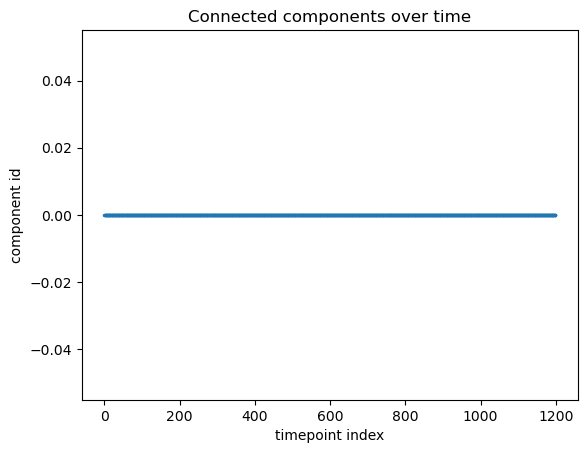

Top neighbors for frame 0:
  neighbor= 645  similarity=0.2146
  neighbor= 443  similarity=0.2007
  neighbor= 860  similarity=0.1885
  neighbor=1165  similarity=0.1791
  neighbor= 876  similarity=0.1779
  neighbor= 827  similarity=0.1756
  neighbor= 177  similarity=0.1734
  neighbor= 788  similarity=0.1704
  neighbor= 369  similarity=0.1696
  neighbor= 100  similarity=0.1689


In [5]:
splines = spline_data # shape (1200, 350, 2)

# Build posture feature vectors
X = build_feature_matrix(
    splines,
    P_resample=350,
    do_resample=False,   # set True if different frames have different P
    do_smooth=False,
    smooth_window=21,
    smooth_poly=3,
)

# Build graph: connect each timepoint to its 10 most similar timepoints
k = 10
G, (dists, idxs) = build_similarity_graph(X, k=k, metric="cosine", make_undirected=True)

# Check connectivity
is_conn, comps = check_connected(G)
print(f"Graph connected? {is_conn}")
print(f"Number of components: {len(comps)}")
if not is_conn:
    sizes = [len(c) for c in comps]
    print("Component sizes (descending):", sorted(sizes, reverse=True)[:10])

# Optional: visualize component structure (simple scatter of node index vs component id)
comp_id = np.full(G.number_of_nodes(), -1, dtype=int)
for cid, nodes in enumerate(comps):
    comp_id[nodes] = cid

plt.figure()
plt.plot(comp_id, ".", markersize=3)
plt.xlabel("timepoint index")
plt.ylabel("component id")
plt.title("Connected components over time")
plt.show()

# Optional: inspect neighbors for a particular frame
t0 = 0
neighbors = idxs[t0, 1:k+1]
sims = 1.0 - dists[t0, 1:k+1]
print("Top neighbors for frame 0:")
for n, s in zip(neighbors, sims):
    print(f"  neighbor={int(n):4d}  similarity={s:.4f}")


# similarity matrix

In [6]:
def pairwise_similarity_matrix(
    X: np.ndarray,
    metric: str = "cosine",
    eps: float = 1e-12,
    block_size: int | None = 512,
    dtype_out=np.float32,
) -> np.ndarray:
    """
    Compute an explicit all-pairs similarity matrix S of shape (T, T).

    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (T, D). (E.g., output of build_feature_matrix.)
    metric : str
        "cosine"  -> S[i,j] = cosine similarity in [-1,1] (typically [0,1] if features are nonnegative-ish)
        "corr"    -> S[i,j] = Pearson correlation across features (equiv. cosine on mean-centered rows)
        "dot"     -> S (unnormalized) = X @ X.T
        "neg_l2"  -> S[i,j] = -||xi - xj||^2 (bigger is more similar)
    eps : float
        Small constant to avoid divide-by-zero.
    block_size : int | None
        If None, computes in one shot (may be memory heavy).
        If int, computes S in blocks over rows to reduce peak memory.
    dtype_out :
        Output dtype.

    Returns
    -------
    S : np.ndarray
        Similarity matrix (T, T).
    """
    X = np.asarray(X, dtype=np.float32)
    T, D = X.shape

    def _cosine_rows(A: np.ndarray) -> np.ndarray:
        norms = np.linalg.norm(A, axis=1, keepdims=True) + eps
        return A / norms

    if metric.lower() == "corr":
        # Pearson correlation across features: center each row then cosine
        Xw = X - X.mean(axis=1, keepdims=True)
        Xn = _cosine_rows(Xw)
        base = Xn
        mode = "dot"
    elif metric.lower() == "cosine":
        Xn = _cosine_rows(X)
        base = Xn
        mode = "dot"
    elif metric.lower() == "dot":
        base = X
        mode = "dot"
    elif metric.lower() == "neg_l2":
        # We'll compute -||xi-xj||^2 = -(||xi||^2 + ||xj||^2 - 2 xi·xj)
        base = X
        mode = "neg_l2"
        x2 = np.sum(X * X, axis=1, keepdims=True)  # (T,1)
    else:
        raise ValueError(f"Unknown metric: {metric}. Use 'cosine', 'corr', 'dot', or 'neg_l2'.")

    S = np.empty((T, T), dtype=dtype_out)

    if block_size is None:
        if mode == "dot":
            S[:] = (base @ base.T).astype(dtype_out, copy=False)
        else:  # neg_l2
            G = base @ base.T  # (T,T)
            S[:] = (-(x2 + x2.T - 2.0 * G)).astype(dtype_out, copy=False)
        return S

    # Blocked computation over rows
    bs = int(block_size)
    for i0 in range(0, T, bs):
        i1 = min(T, i0 + bs)
        Bi = base[i0:i1]  # (bs,D)

        if mode == "dot":
            S[i0:i1, :] = (Bi @ base.T).astype(dtype_out, copy=False)
        else:
            Gi = Bi @ base.T                       # (bs,T)
            x2i = np.sum(Bi * Bi, axis=1, keepdims=True)  # (bs,1)
            S[i0:i1, :] = (-(x2i + x2.T - 2.0 * Gi)).astype(dtype_out, copy=False)

    return S





In [15]:
X = build_feature_matrix(splines, do_smooth=True)
S = pairwise_similarity_matrix(X, metric="dot", block_size=None)
# Now S[i,j] is similarity between timepoints i and j.

In [16]:
S.shape

(1200, 1200)

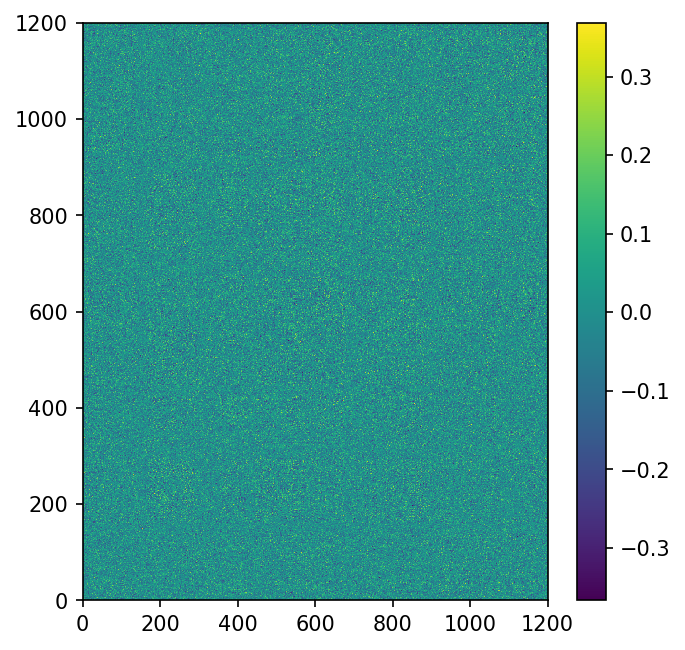

In [19]:
S_vis = S.copy()
np.fill_diagonal(S_vis, 0)

plt.figure(figsize=(5,5), dpi=150)
plt.pcolor(S_vis)
plt.colorbar()
plt.show()


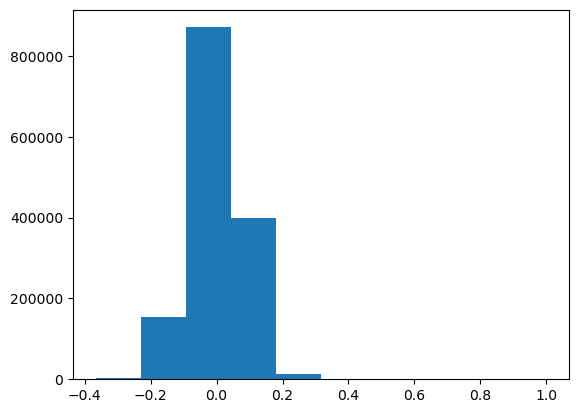

In [18]:
plt.figure()
plt.hist(S.ravel())
plt.show()

# tsne splines

In [29]:
def tsne_embed_splines(
    splines: np.ndarray,
    feature_matrix: np.ndarray | None = None,
    perplexity: float = 30.0,
    n_components: int = 2,
    metric: str = "cosine",
    learning_rate: str | float = "auto",
    init: str = "pca",
    verbose: int = 1,
):
    """
    Embed each timepoint's spline posture into 2D/3D with t-SNE (scikit-learn).

    Parameters
    ----------
    splines : np.ndarray
        Array of splines with shape (T, P, 2).
    feature_matrix : np.ndarray | None
        If provided, use this (shape (T, D)) instead of recomputing features from splines.
        This should typically be your posture feature vectors (e.g., angle-difference features).
    perplexity : float
        t-SNE perplexity (roughly, #neighbors). Must be < T.
    n_components : int
        2 or 3.
    metric : str
        Distance metric for t-SNE: "cosine", "euclidean", etc.
    learning_rate : "auto" or float
    n_iter : int
        Number of optimization iterations.
    init : str
        "pca" or "random".
    random_state : int
        For reproducibility.
    verbose : int
        0/1/2.

    Returns
    -------
    Y : np.ndarray
        t-SNE embedding of shape (T, n_components).
    X : np.ndarray
        Feature matrix actually used, shape (T, D).
    tsne : TSNE
        The fitted TSNE object.
    """
    # If you already computed X = build_feature_matrix(splines, ...)
    # pass it as feature_matrix to avoid recomputing.
    if feature_matrix is None:
        # expects you defined build_feature_matrix from earlier
        X = build_feature_matrix(
            splines,
            do_resample=False,
            do_smooth=False,
            smooth_window=21,
            smooth_poly=3,
        )
    else:
        X = np.asarray(feature_matrix)

    T = X.shape[0]
    if perplexity >= T:
        raise ValueError(f"perplexity must be < number of samples. Got perplexity={perplexity}, T={T}.")

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        metric=metric,
        learning_rate=learning_rate,
        init=init,
        verbose=verbose,
    )
    Y = tsne.fit_transform(X)
    return Y, X, tsne

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.221728


c:\Users\munib\miniconda3\envs\g5ht-pipeline\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.739136
[t-SNE] KL divergence after 1000 iterations: 2.907475


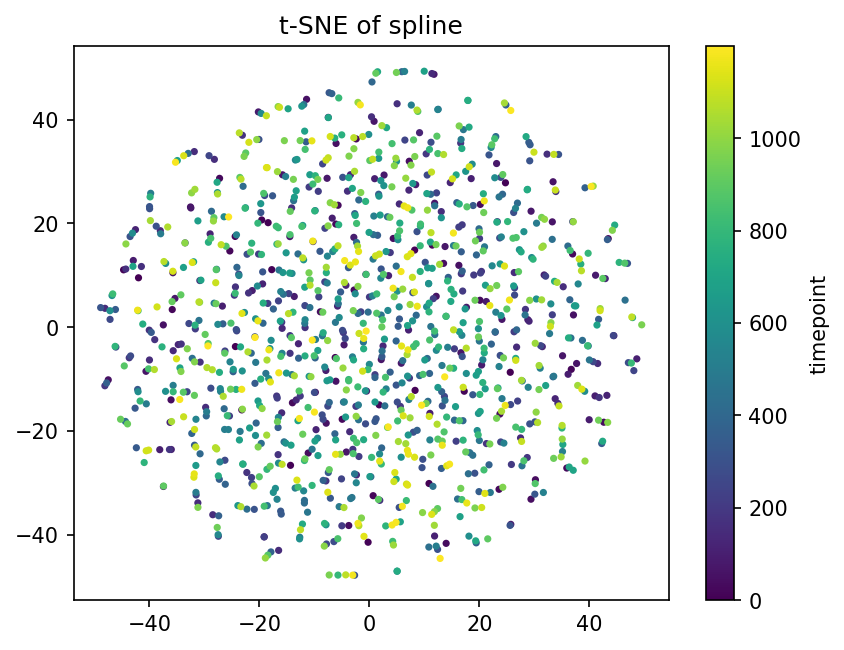

In [33]:
Y, X, tsne = tsne_embed_splines(splines, perplexity=20, metric="euclidean")
plt.figure(dpi=150)
plt.scatter(Y[:,0], Y[:,1], s=6, c=np.arange(Y.shape[0]), cmap="viridis")
plt.colorbar(label="timepoint")
plt.title("t-SNE of spline")
plt.show()

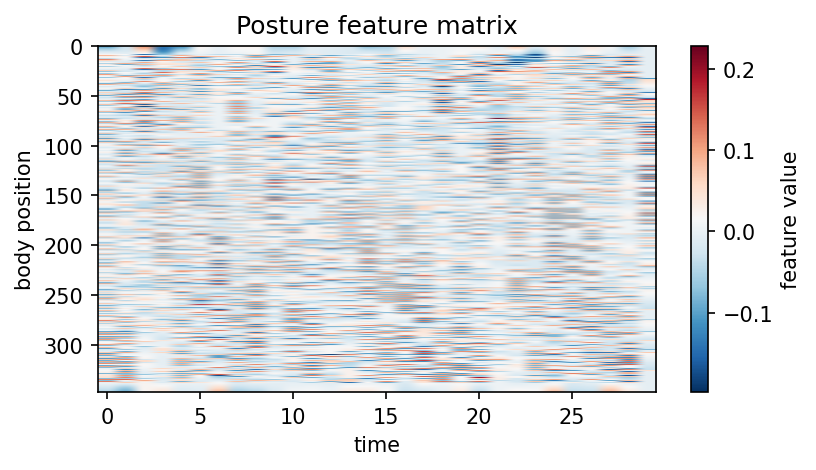

In [37]:

X = build_feature_matrix(splines)
plt.figure(figsize=(6,3),dpi=150)
plt.imshow(X[0:30,:].T, aspect="auto", cmap="RdBu_r")
plt.colorbar(label="feature value")
plt.xlabel("time")
plt.ylabel("body position")
plt.title("Posture feature matrix")
plt.show()


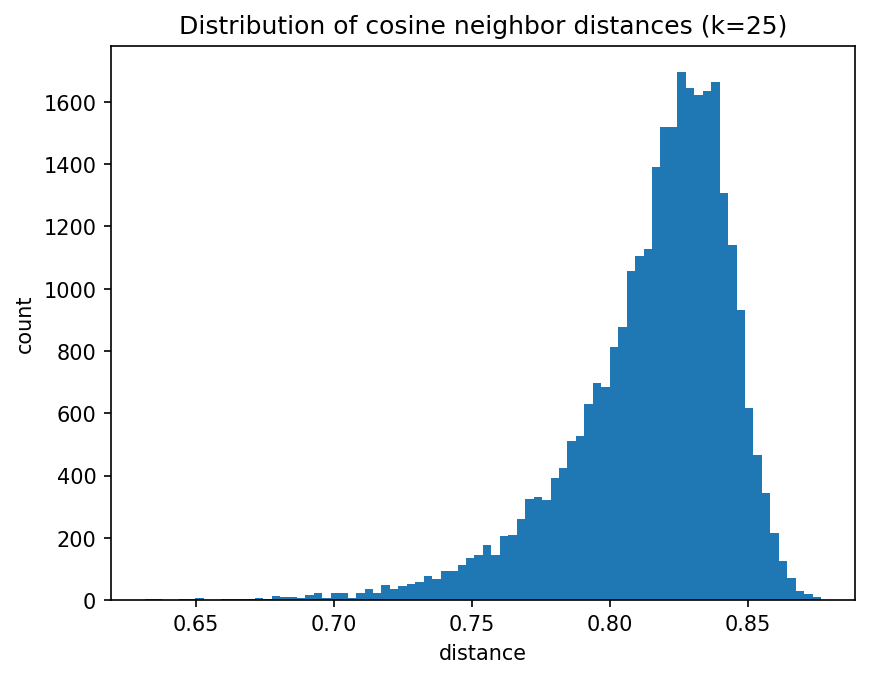

Cosine similarity: median top-k = 0.178, 95th pct = 0.240


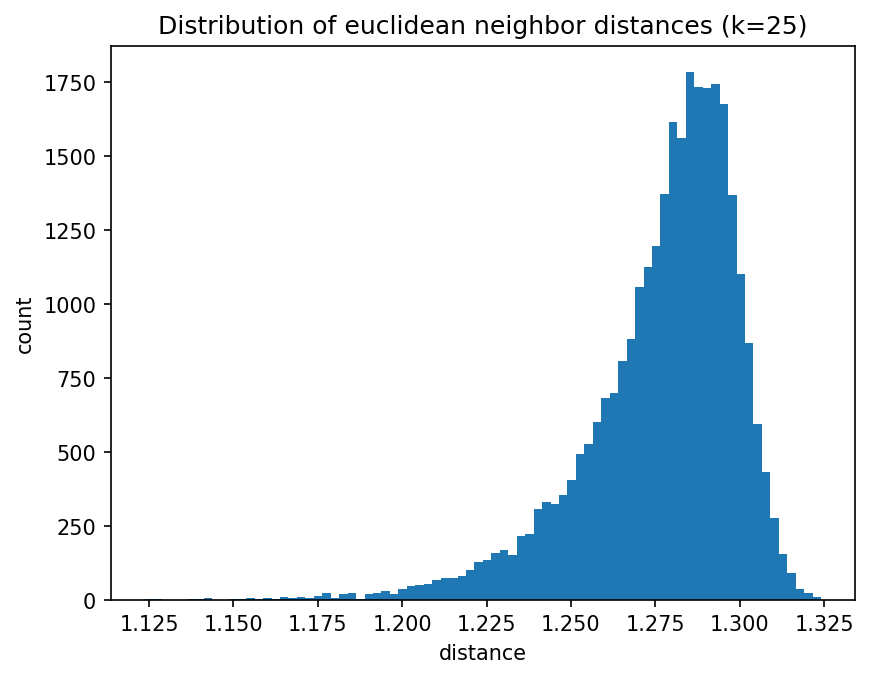

Distances: median top-k = 1.282, 5th pct = 1.233


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def neighbor_diagnostic(X, metric="cosine", k=25):
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nn.fit(X)
    dists, idxs = nn.kneighbors(X)

    # drop self-neighbor at column 0
    d = dists[:, 1:]

    plt.figure(dpi=150)
    plt.hist(d.ravel(), bins=80)
    plt.title(f"Distribution of {metric} neighbor distances (k={k})")
    plt.xlabel("distance")
    plt.ylabel("count")
    plt.show()

    # If cosine: convert to similarity
    if metric == "cosine":
        s = 1.0 - d
        print(f"Cosine similarity: median top-k = {np.median(s):.3f}, 95th pct = {np.percentile(s,95):.3f}")
    else:
        print(f"Distances: median top-k = {np.median(d):.3f}, 5th pct = {np.percentile(d,5):.3f}")

# X should be your feature matrix (T,D), e.g. from build_feature_matrix(...)
neighbor_diagnostic(X, metric="cosine", k=25)
neighbor_diagnostic(X, metric="euclidean", k=25)


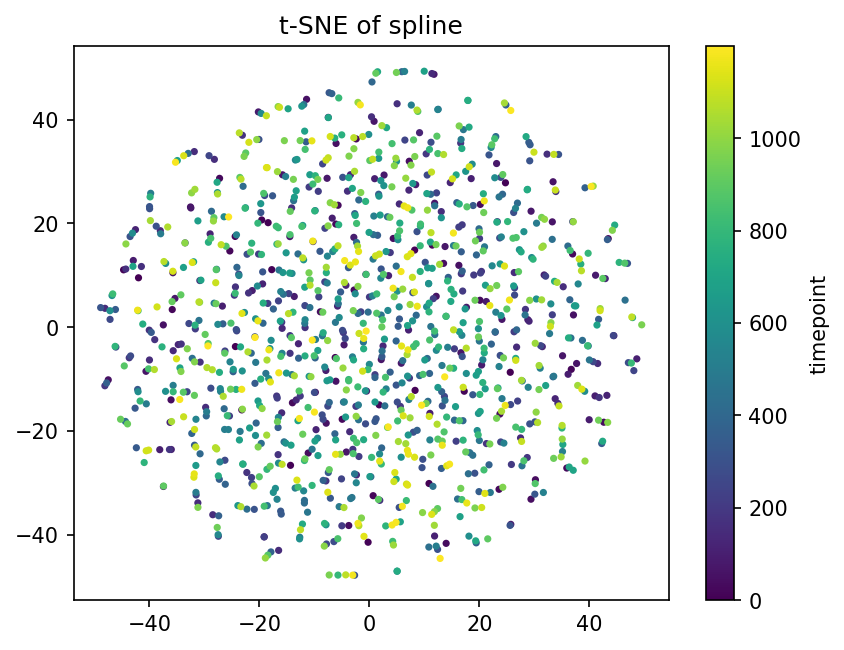

In [42]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def tsne_embed_postures(
    X,
    n_components=2,
    metric="cosine",
    perplexity=30,
    pca_dims=50,
    standardize=False,
    init="pca",
    learning_rate="auto",
    early_exaggeration=12.0,
    random_state=0,
    verbose=1,
):
    """
    X: (T,D) feature matrix (rows=timepoints)
    Returns Y: (T,2)
    """
    X = np.asarray(X, dtype=np.float32)

    if standardize:
        X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

    if pca_dims is not None and pca_dims < X.shape[1]:
        Xp = PCA(n_components=pca_dims, random_state=random_state).fit_transform(X)
    else:
        Xp = X

    if perplexity >= Xp.shape[0]:
        raise ValueError("perplexity must be < number of samples")

    tsne = TSNE(
        n_components=n_components,
        metric=metric,
        perplexity=perplexity,
        init=init,
        learning_rate=learning_rate,
        early_exaggeration=early_exaggeration,
        random_state=random_state,
        verbose=verbose,
    )
    Y = tsne.fit_transform(Xp)
    return Y

plt.figure(dpi=150)
plt.scatter(Y[:,0], Y[:,1], s=6, c=np.arange(Y.shape[0]), cmap="viridis")
plt.colorbar(label="timepoint")
plt.title("t-SNE of spline")
plt.show()

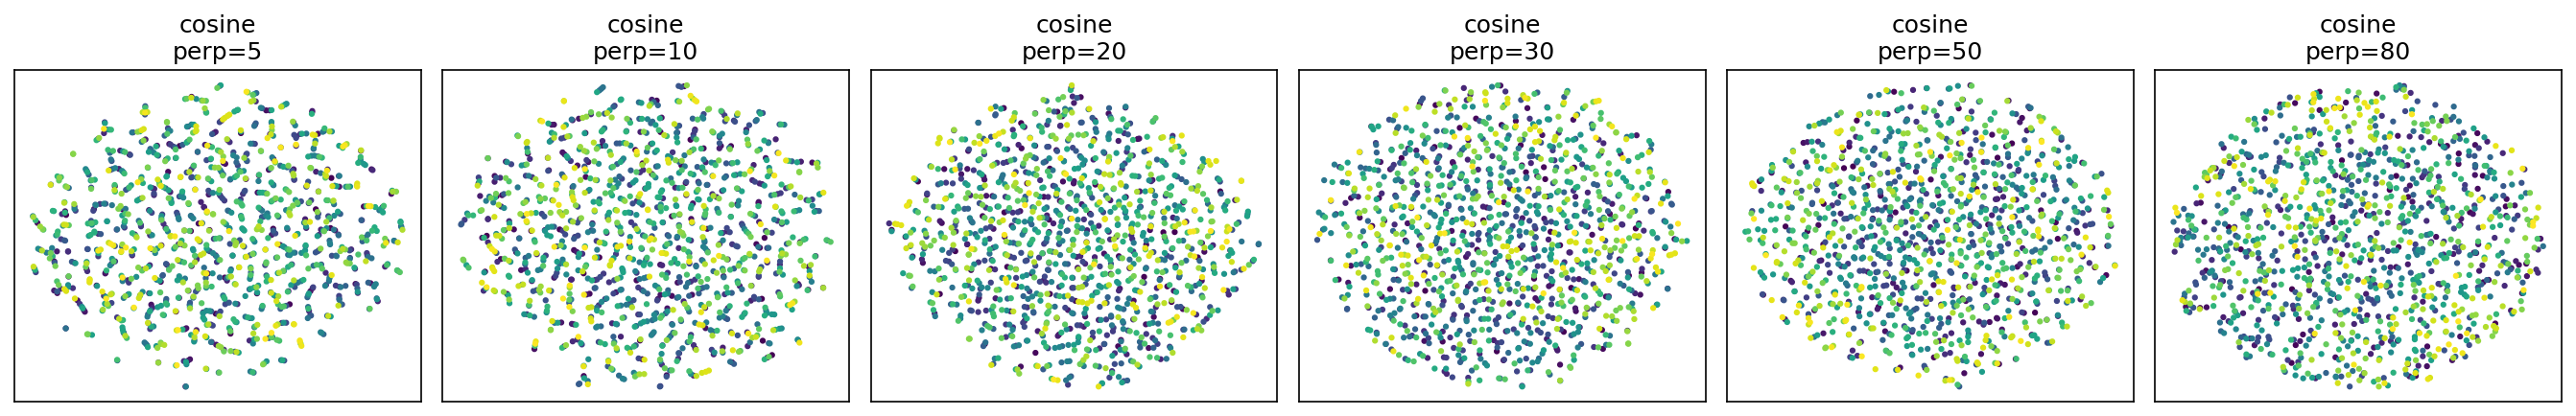

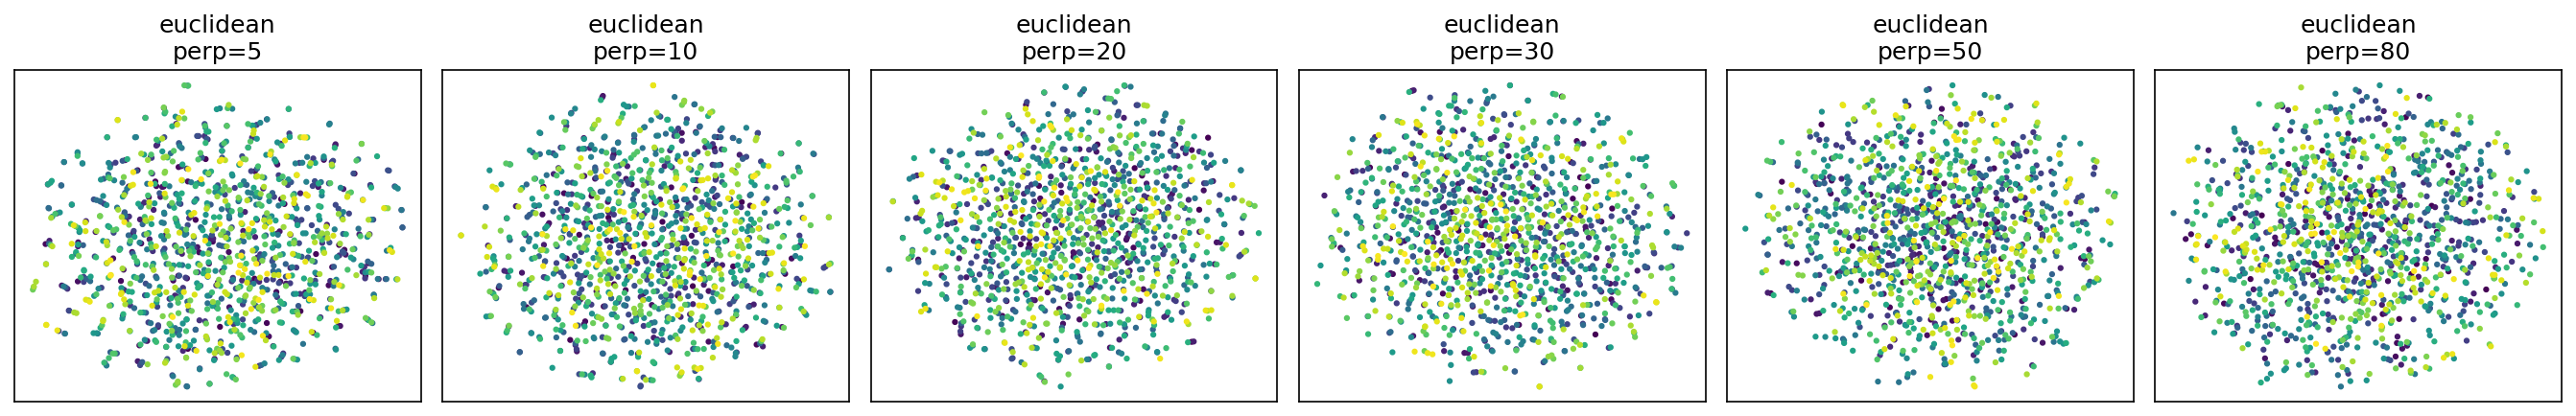

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_sweep(X, perplexities=(5, 10, 20, 30, 50, 80), metrics=("cosine","euclidean")):
    t = np.arange(X.shape[0])
    for metric in metrics:
        plt.figure(figsize=(len(perplexities)*3, 3), dpi=150)
        for i, per in enumerate(perplexities, 1):
            Y = tsne_embed_postures(X, metric=metric, perplexity=per, pca_dims=50, standardize=False, random_state=0, verbose=0)
            ax = plt.subplot(1, len(perplexities), i)
            sc = ax.scatter(Y[:,0], Y[:,1], s=4, c=t, cmap="viridis")
            ax.set_title(f"{metric}\nperp={per}")
            ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout()
        plt.show()

plot_tsne_sweep(X)


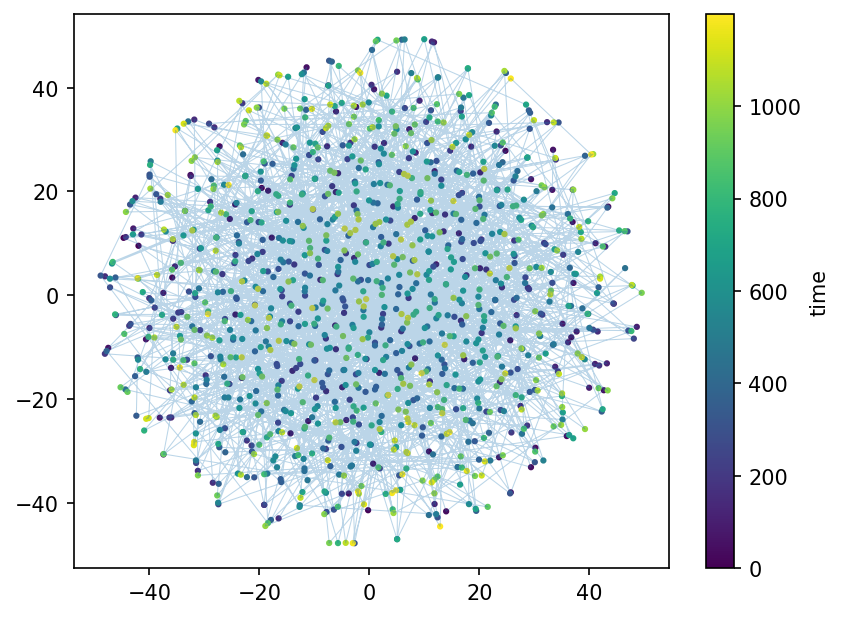

In [44]:
plt.figure(dpi=150)
plt.plot(Y[:,0], Y[:,1], '-', linewidth=0.5, alpha=0.3)
plt.scatter(Y[:,0], Y[:,1], s=4, c=np.arange(len(Y)), cmap="viridis")
plt.colorbar(label="time")
plt.show()
